# Data Intelligence Application Project 
### Pricing and Adverticing

<br/><br/>
## Overview
The project analyzes a common scenario in the pricing and advertising fields. The goal is to jointly maximize the revenue of a product based on the price and the bid of the advertiser.

The process is divided into experiments that analyze different degrees of freedom of the variables involved in the maximization problem




In [1]:
from customerManager import CustomerManager
import matplotlib.pyplot as plt
import numpy as np

from experiments.experiment1 import experiment1run
from experiments.experiment2 import Experiment2
from experiments.experiment3 import Experiment3

from experiments.experiment5 import Experiment5
from experiments.experiment6 import Experiment6
from experiments.experiment7 import Experiment7


customer_path = "./config/customer_classes.json"
cManager = CustomerManager(file_path = customer_path)

## Real world scenario
The reference enviroment is an ecommerce website in the wine sector. The company's request is to optimize the cost of the advertising campaign and the price of their new wine based on the customer's characteristics.Speaking about the Advertising environment, we supposed that the auction follows a GSP allocation mechanism and that in the considered bid range there will always be a bidder close to our value.

### User
The Identified users classes are defined by characteristics linked to economic resources and the frequency of purchase of wine products.

    - Class 0  =  Wealthy and frequent buyer 
    - Class 1  =  Wealthy and not frequent  
    - Class 2  =  Frequent, but "smart"
### Product
The wine was chosen as product because it suits well to the study of the purchase periodicity and it allows cost variability according to the individual class of user.

<br/><br/><br/>


### Data
#### Click Function
We suppose that the click function is a logistic function that saturates at differente levels depending on the user class. Use this approximation because we expect more click from frequent buyers to occasional ones with the same bid value.

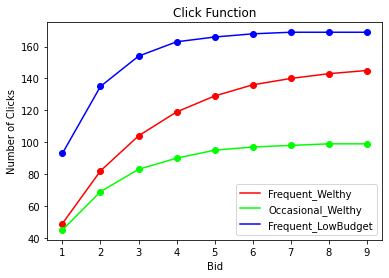

In [7]:
#Data Generation
X = np.arange(1,10)
Y = []
for c in cManager.classes:
    Y.append([])
    for x in X:
        Y[c["class_id"]].append(cManager.clicks(c["class_id"], bid = x, noise = False)) 


#Plotting of click function
plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]
for c in cManager.classes:    
    plt.plot(X, Y[c["class_id"]], color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter(X, Y[c["class_id"]], color=colors[c["class_id"]])
    plt.title("Click Function")
    plt.xlabel("Bid")
    plt.ylabel("Number of Clicks")


plt.legend()
plt.show()

#### Cost per click
Due to the constraint bid range and CSP hypothesis, we considered that for each bid there will be an advertiser very close to our value. This will cause the cost per click function to be upper bound by our bid value.

#### Conversion rate
**Conversion rates** have been chosen to best represent the willingness of the different types of users to purchase the product at the various price values.

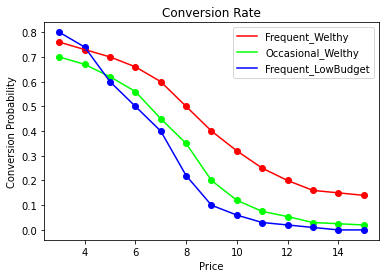

In [8]:
import matplotlib.pyplot as plt
import numpy as np


#Plotting 
plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]
for c in cManager.classes:    
    plt.plot([i[0] for i in c["conversion_rate_matrix"]],
             [i[1] for i in c["conversion_rate_matrix"]], 
             color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter([i[0] for i in c["conversion_rate_matrix"]],
                [i[1] for i in c["conversion_rate_matrix"]],
                color=colors[c["class_id"]])
    plt.title("Conversion Rate")
    plt.xlabel("Price")
    plt.ylabel("Conversion Probability")


plt.legend()
plt.show()

#### Comeback rate
This rappresentation of **comeback rate** is been suppose to fit a possible distribution of repeted purchase by different class of user. This could be easily computed in a real world scenario from the statistic of purchase of the ecommerce.

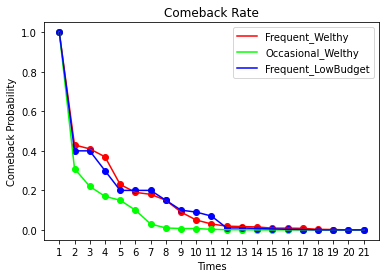

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
colors = [[1,0,0] , [0,1,0 ], [0,0,1]]

X = np.arange(1, 22)
Y = []


#Data Generation
for c in cManager.classes:
    Y.append([])
    for x in X:
        Y[c["class_id"]].append(cManager.comeback_probability(c["class_id"], times = x, noise = False)) 



#Plotting 
for c in cManager.classes:    
    plt.xticks(X)
    plt.plot(X,
             Y[c["class_id"]], 
             color=colors[c["class_id"]], label = c["name"])
    
    plt.scatter(X,
                Y[c["class_id"]], 
                color=colors[c["class_id"]])
    plt.title("Comeback Rate")
    plt.xlabel("Times")
    plt.ylabel("Comeback Probability")


plt.legend()
plt.show()



# Objective Function
Maximizing the revenue, given as the difference between the reward (profit) and the cost per click times the clicks ( costs ). 

It can be expressed as :
### $$ max_{p,b}( \sum \limits_{C_i} (p \times soldItems(b_i, p)) - (clicks(b_i) \times costPerClick(b_i))) $$


with the following constraints:
$$ p >= 3  $$
$$ p <= 15  $$
$$ 0 < b_i < 10  \hspace{5mm} \forall i $$
$$ \sum(costPerClick(b_i)) <= B  $$

where:
- $p$ is the price of the product
- $b$ is the cost for the advertising campaign in a day for a specific class *i*
- $B$ is the daily budget for the advertising campaign
- $C$ is the set of customer classes
- $soldItems(b_i, p)$ is the amount of sold item given in input bid and price
- $clicks(b_i)$ is the amount of click given a bid
- $costPerClick(b_i)$ is the cost for each click given the bid

The last constraint is not needed due to the missing of a limited budget. 

### 1. Best joint strategy with known parameter

The first step of out work was to evaluate the optimal bidding/pricing pairs when all the parameters were known and not noisy. To do so, we used the optimization algorithm provided in the "scipy.optimize.minimize" package. This algorithm allows to optimize an objective function with possibility of fixing some constraints. Here we report the result, that provides the best "bids, price" set with a clairvoyant   algorithm. This set has been used in the successive steps to analyse the efficiency of the implemented algorithms.
An empirical analysis of the execution time of the function optimize.minimize (used to evaluate the optimal joint bid/price point) provided almost constant results using 10 bids/price  and 1000 possible values. From this we deduce that the complexity of the algorithm is probably linear in the input range.

In [2]:
experiment1run()

100%|██████████| 50/50 [00:02<00:00, 23.08it/s]

Best method is none with a value of 2408.564591760646
Optimal Solution
bid 1 = 3.8622485250603975
bid 2 = 2.182222380639664
bid 3 = 2.396153281225892
price = 6.316003595955636



### 2. Best joint strategy with known parameter in online enviroment
The goal of this step was to implement an online learning algorithm to correctly learn the best bid/price combination in a noisy environment. To achieve this goal we implemented a Gaussian Process based learner that at each time steps calculates the best bids/price pair according to the information it has collected. The best pair is so used for a day and then when the outcome is received the gaussian process fits the revenue function adding the new point.
<br/><br/>
Regrets are calculated using as benchmark the optimal joint bids/price set calculated at Step 1.


### No delay


In [5]:
experiment = Experiment2()
experiment.run()

100%|██████████| 365/365 [01:34<00:00,  3.85it/s]


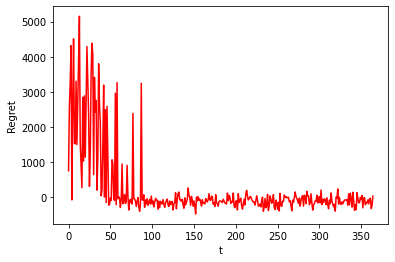

In [6]:
experiment.showRegret()

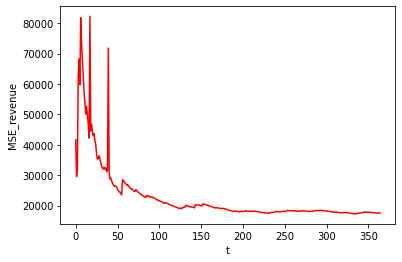

In [7]:
experiment.showMSE()

### Delay

100%|██████████| 365/365 [01:21<00:00,  4.48it/s]


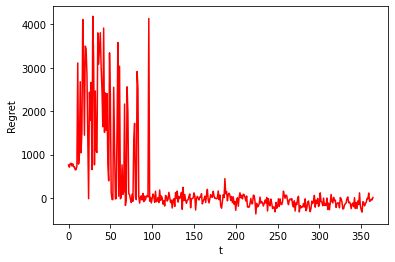

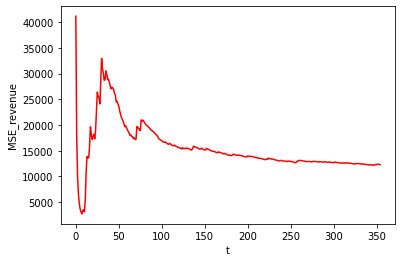

In [2]:
delay = 10
experiment = Experiment2(delay)
experiment.run()
experiment.showRegret()
experiment.showMSE()

### 3. Best pricing strategy with known parameter , fixed bid and no discrimination among customers in online enviroment
This Experiment tries to compute the optimal price given a fixed set of bids. In this scenario the algorithm doesn't discriminate among customers classes. Here it's implemented both with a TS learner and a UCB1 learner.

In [2]:
experiment3 = Experiment3()
experiment3.run()

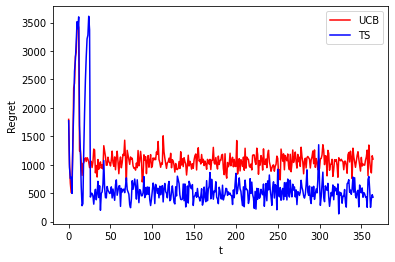

In [3]:
experiment3.showRegret()

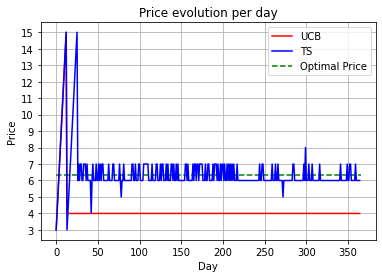

In [4]:
experiment3.showPriceEvolution()

### 4. titolo

### 5. Best bidding strategy with fixed price, know parameter, not discimination among users and safety constraint in online enviroment
In this experiment we used Thompson Sampling to learn the best bidding strategy when the price is fixed and the customer information is not known.  Our implementation of the TS algorithm has an optional attribute to implement a "safety-block" to stop the algorithm from playing losing arms (negative reward).

In [2]:
experiment5 = Experiment5()
experiment5.run()

100%|██████████| 365/365 [00:00<00:00, 816.53it/s]


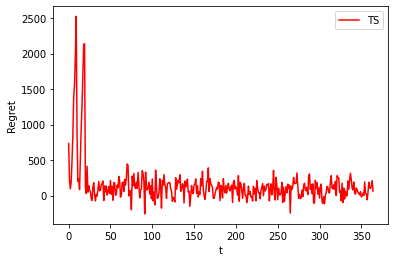

In [3]:
experiment5.showRegret()

### 6. Best joint strategy with known parameter, no discrimination among customers and safety constraint in online enviroment
Here we  simply adapted the TS learner algorithm to solve the joint problem with aggregated user classes.

In [2]:
experiment6 = Experiment6()
experiment6.run()

100%|██████████| 365/365 [00:00<00:00, 1638.27it/s]


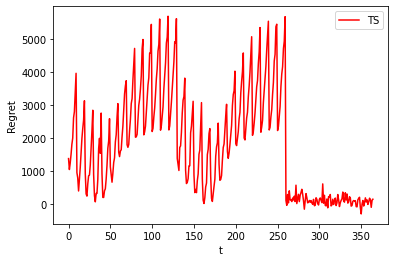

In [3]:
experiment6.showRegret()

### 7. Best joint strategy with known parameter , fixed bid, discrimination among customers and safety constraint in online enviroment
Solves the joint problem with user discrimination as in step 2, but with a different approach

In [4]:
experiment7 = Experiment7()
experiment7.run()

100%|██████████| 365/365 [00:00<00:00, 854.81it/s] 


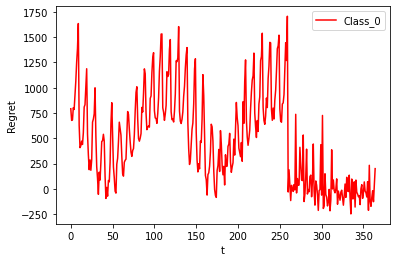

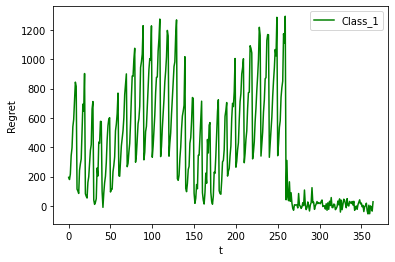

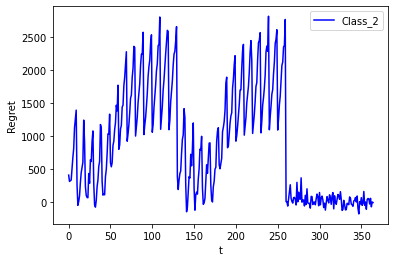

In [5]:
experiment7.showRegret()